# Analysing NOAA Images obtained with Satdump

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danselem/dara_opsc/blob/main/notebooks/pcor.ipynb)


<div style="text-align: center;">
  <img src="https://www.nesdis.noaa.gov/s3/styles/webp/s3/migrated/JPSS-1.jpg.webp?itok=KGtqS1df" width="1000"/>
</div>

In this tutorial, we will be using the NOAA data obtained on the 11th of July 2025 with Satdump.

The data comprises multiple images images including transformations performed with Satdump as well as the product parameters. This tutorial is performed with Python and is run in Jupyter Notebook environment running in Google Colab instance.

If you're not familiar with Python, then I recommend you check out the Week 1 of this Github project repo: <https://github.com/Danselem/brics_astro/tree/main/Week1>.

## Installing Packages

In Python, **packages** are reusable blocks of code developed by the open-source community.  
They save time by allowing us to use tested functions and tools instead of writing everything from scratch.  
For this project, we will install a few essential packages using **Pip**, Python’s package manager.

- **`cbor2`** — Handles **CBOR (Concise Binary Object Representation)** files, a compact binary format used to store structured data such as satellite product metadata.  
- **`skyfield`** — Performs precise **astronomical and orbital calculations**, helping us determine satellite positions, trajectories, and observation times.  
- **`cartopy`** — A **mapping and geospatial visualization** library for displaying satellite footprints, coastlines, and projections on global maps.  
- **`rasterio`** — Enables reading and writing of **raster-based geospatial images**, allowing us to georeference satellite data and extract pixel information.  
- **`scikit-image`** — Provides a wide range of **image processing algorithms** for filtering, segmentation, and feature extraction such as edge or texture detection.  
- **`opencv-python`** — A powerful **computer vision** library used for image enhancement, artifact detection, and motion or object analysis.  


In [ ]:
!pip install -q cbor2 skyfield cartopy rasterio
!pip install -q scikit-image opencv-python

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cbor2

In [2]:
ls ../data

2025-07-11_05-39_noaa_apt_137MHz/       Re Mini workshop update (Forthare).zip


### Reading Satellite Product Metadata

This code snippet reads a satellite product stored in the Concise Binary Object Representation (CBOR) format. CBOR is a compact and efficient binary serialization widely used for Earth observation data. The file is opened in binary mode and parsed using `cbor2.load`, which reconstructs the original Python dictionary containing the complete product metadata.  

The decoded metadata includes imaging parameters such as image width, height, and timestamps; satellite orbital data, including the Two-Line Element (TLE) information; and projection configuration parameters, such as scan angles and acquisition times. Together, these components form the foundational dataset required for geospatial analysis.  

This metadata will be used later to compute geometric and spatial metrics such as the satellite subpoint, along-track and across-track ground coverage, pixel dimensions, total imaged area, and field of view (FoV), which are essential for accurate georeferencing and visualization of satellite imagery within a global coordinate reference system.

In [3]:
# Read CBOR file
with open("../data/2025-07-11_05-39_noaa_apt_137MHz/product.cbor", "rb") as f:
    product = cbor2.load(f)

### Inspecting the Data

In [5]:
product.get('projection_cfg', {})

{'gcp_spacing_x': 30,
 'gcp_spacing_y': 30,
 'image_width': 909,
 'pitch_offset': 0,
 'roll_offset': -0.01,
 'scan_angle': 110.6,
 'timefilter': {'max_diff': 1.0, 'scan_time': 0.2, 'type': 'simple'},
 'timestamp_offset': 0.1,
 'type': 'noaa_apt_single_line',
 'yaw_offset': -0.6}

In [6]:
product.get('tle', {})

{'line1': '1 33591U 09005A   25191.84763408  .00000140  00000+0  98745-4 0  9994',
 'line2': '2 33591  98.9961 256.7258 0012673 275.6010  84.3716 14.13387505846262',
 'name': 'NOAA 19',
 'norad': 33591}

In [8]:
timestamps = product.get('timestamps', [])
print(len(timestamps))

860


## Computing Metrics from Product

This section computes essential geometric and temporal metrics that describe how a satellite captures an image of the Earth's surface. Using the product’s timestamps and Two-Line Element (TLE) data, the function determines the mid-acquisition time, sub-satellite points, along-track and across-track distances, pixel resolutions, total ground area, and field of view. These parameters together define the spatial coverage, scale, and imaging geometry of the satellite observation.

The calculations combine geodesy, trigonometry, and photogrammetric principles — for example, the haversine formula estimates along-track distances, while the swath width is derived from the satellite’s altitude and sensor field of view. This allows one to relate image pixels to real ground distances and interpret satellite imagery in a physically meaningful way.  

An illustration of the satellite imaging geometry, showing the along-track, across-track, swath, and field-of-view relationships, is presented in Figure 1.

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/Danselem/dara_opsc/main/satimage.png" width="450"/>
  <p><strong>Figure 1.</strong> Satellite imaging geometry showing along-track, across-track, swath, and field-of-view (FOV) relationships.</p>
</div>



## Metrics Description

This section explains each metric derived from the satellite product and its scientific significance in the context of Earth observation. These metrics link satellite orbital geometry, sensor characteristics, and image representation on the ground.

**image_width_px** and **image_height_px** represent the number of pixels along the across-track (width) and along-track (height) directions of the image. The width comes from the projection configuration, while the height is inferred from the number of timestamps, each corresponding to one scan line in APT-like sensors. Together, they define the sampling grid of the sensor.

**mid_datetime** is the acquisition time at the midpoint of the image, computed as the mean of the first and last timestamp:

$$
t_\text{mid} = \frac{t_0 + t_N}{2}
$$

It serves as the temporal reference for locating the satellite and aligning the image with ground coordinates.

**mid_subpoint** is the geographic location (latitude, longitude) and altitude of the satellite at the mid-acquisition time. Using Skyfield and the satellite’s TLE, the satellite’s position is propagated to this time, and the subpoint corresponds to the location on Earth directly below the satellite. This defines the image center on the ground.

**first_subpoint** and **last_subpoint** denote the sub-satellite positions at the beginning and end of the acquisition. They determine the endpoints of the satellite’s ground track and help calculate how far the satellite moved during imaging.

**along_track_length_km** measures the ground distance between the first and last subpoints along the orbit, using the haversine formula to account for Earth’s curvature:

$$
d = 2 R \arcsin \left( \sqrt{ \sin^2 \frac{\Delta \phi}{2} + \cos \phi_1 \cos \phi_2 \sin^2 \frac{\Delta \lambda}{2} } \right)
$$

where $\Delta \phi$ and $\Delta \lambda$ are the differences in latitude and longitude (in radians), and $R$ is Earth’s radius.

**along_track_pixel_size_m** represents the ground resolution along the satellite’s flight path:

$$
\text{pixel size along-track} = \frac{\text{along-track length (m)}}{\text{number of scan lines}}
$$

This gives the real-world distance each pixel covers in the along-track direction.

**across_track_swath_km** quantifies the ground width imaged perpendicular to the orbit, derived from the satellite altitude $h$ and the sensor field-of-view $\theta$:

$$
\text{swath} = 2 h \tan \frac{\theta}{2}
$$

It defines how wide an area the sensor can capture in one pass.

**across_track_pixel_size_m** expresses the across-track ground distance per pixel:

$$
\text{pixel size across-track} = \frac{\text{swath (m)}}{\text{image width (pixels)}}
$$

This determines spatial resolution across the swath and is essential for surface feature interpretation.

**total_ground_area_km2** estimates the total area covered by the image footprint:

$$
\text{total area} = \text{along-track length} \times \text{across-track swath}
$$

This approximates the spatial extent of the satellite acquisition in square kilometers.

**per_pixel_area_km2** gives the area represented by a single pixel:

$$
\text{per-pixel area} = \frac{\text{pixel size along-track (m)} \times \text{pixel size across-track (m)}}{10^6}
$$

It’s useful for quantitative analyses such as estimating surface reflectance or flux densities.

**fov_deg** refers to the sensor’s field-of-view in degrees, derived from the scan angle in the product. It determines the angular width of the imaged swath on the ground.

By combining these metrics, the geometric footprint, resolution, and coverage of a satellite image can be quantitatively described, allowing rigorous interpretation and comparison of remote sensing data.  


In [10]:
# Python 3
from datetime import datetime, timezone
from math import radians, tan, sin, cos, sqrt, asin
from skyfield.api import EarthSatellite, load

def compute_product_metrics(product: dict) -> dict:
    """
    Compute satellite image metrics from a product dictionary.
    Returns all values as native Python types (float, int, str) including FOV.
    """

    # --- image dimensions ---
    proj = product.get('projection_cfg', {})
    image_width = int(proj.get('image_width'))
    timestamps = product.get('timestamps', [])
    image_height = len(timestamps)
    if image_height == 0:
        raise ValueError("no timestamps found")

    # --- midtime ---
    mid_ts = 0.5 * (timestamps[0] + timestamps[-1])
    mid_datetime = datetime.fromtimestamp(mid_ts, tz=timezone.utc)

    # --- TLE and satellite ---
    tle = product.get('tle', {})
    line1 = tle.get('line1')
    line2 = tle.get('line2')
    name = tle.get('name', 'sat')
    if not line1 or not line2:
        raise ValueError("TLE lines missing")
    sat = EarthSatellite(line1, line2, name)
    ts_sf = load.timescale()

    # --- helper: POSIX -> Skyfield time ---
    def to_sf_time(posix_ts):
        dt = datetime.fromtimestamp(posix_ts, tz=timezone.utc)
        return ts_sf.utc(dt.year, dt.month, dt.day,
                         dt.hour, dt.minute, dt.second + dt.microsecond/1e6)

    # --- mid subpoint ---
    sub_mid = sat.at(to_sf_time(mid_ts)).subpoint()
    mid_subpoint = {
        "lat_deg": float(sub_mid.latitude.degrees),
        "lon_deg": float(sub_mid.longitude.degrees),
        "alt_km": float(sub_mid.elevation.km)
    }

    # --- first and last subpoints ---
    sub0 = sat.at(to_sf_time(timestamps[0])).subpoint()
    subN = sat.at(to_sf_time(timestamps[-1])).subpoint()
    first_subpoint = {
        "lat_deg": float(sub0.latitude.degrees),
        "lon_deg": float(sub0.longitude.degrees)
    }
    last_subpoint = {
        "lat_deg": float(subN.latitude.degrees),
        "lon_deg": float(subN.longitude.degrees)
    }

    # --- haversine along-track length ---
    def haversine_km(lat1, lon1, lat2, lon2):
        R = 6371.0  # Earth radius km
        phi1, phi2 = radians(lat1), radians(lat2)
        dphi = radians(lat2 - lat1)
        dlambda = radians(lon2 - lon1)
        a = sin(dphi/2.0)**2 + cos(phi1)*cos(phi2)*sin(dlambda/2.0)**2
        c = 2*asin(sqrt(a))
        return R * c

    along_track_length_km = haversine_km(sub0.latitude.degrees, sub0.longitude.degrees,
                                         subN.latitude.degrees, subN.longitude.degrees)
    pix_along_m = (along_track_length_km * 1000.0) / image_height

    # --- across-track swath and pixel size ---
    scan_angle_deg = proj.get('scan_angle', 0.0)
    half_angle_rad = radians(scan_angle_deg / 2.0)
    swath_km = 2.0 * float(sub_mid.elevation.km) * tan(half_angle_rad) if scan_angle_deg else None
    pix_across_m = (swath_km * 1000.0) / image_width if swath_km else None

    # --- total area and per-pixel area ---
    area_km2 = swath_km * along_track_length_km if swath_km else None
    per_pixel_km2 = (pix_along_m * pix_across_m) / 1e6 if pix_across_m else None

    # --- FOV (degrees) ---
    fov_deg = float(scan_angle_deg) if scan_angle_deg else None

    # --- assemble metrics ---
    metrics = {
        "image_width_px": int(image_width),
        "image_height_px": int(image_height),
        "mid_datetime": mid_datetime.isoformat(),
        "mid_subpoint": mid_subpoint,
        "first_subpoint": first_subpoint,
        "last_subpoint": last_subpoint,
        "along_track_length_km": float(along_track_length_km),
        "along_track_pixel_size_m": float(pix_along_m),
        "across_track_swath_km": float(swath_km) if swath_km else None,
        "across_track_pixel_size_m": float(pix_across_m) if pix_across_m else None,
        "total_ground_area_km2": float(area_km2) if area_km2 else None,
        "per_pixel_area_km2": float(per_pixel_km2) if per_pixel_km2 else None,
        "fov_deg": fov_deg
    }

    return metrics

metrics = compute_product_metrics(product)
metrics

{'image_width_px': 909,
 'image_height_px': 860,
 'mid_datetime': '2025-07-11T05:46:46.750000+00:00',
 'mid_subpoint': {'lat_deg': -19.29353525433381,
  'lon_deg': 57.87016861985247,
  'alt_km': 852.79286718039},
 'first_subpoint': {'lat_deg': -6.751092775383366,
  'lon_deg': 60.85698089118785},
 'last_subpoint': {'lat_deg': -31.789096873340295,
  'lon_deg': 54.53467310349489},
 'along_track_length_km': 2860.4033287619573,
 'along_track_pixel_size_m': 3326.0503822813453,
 'across_track_swath_km': 2463.178614823465,
 'across_track_pixel_size_m': 2709.7674530511167,
 'total_ground_area_km2': 7045684.309176306,
 'per_pixel_area_km2': 9.012823073114214,
 'fov_deg': 110.6}

In [28]:
# Python 3
from datetime import datetime, timezone
from math import radians, tan
from skyfield.api import EarthSatellite, load
from pyproj import Geod

geod = Geod(ellps='WGS84')

def compute_product_metrics(product: dict) -> dict:
    """
    Compute accurate satellite image metrics with proper corner coordinates,
    along-track and across-track distances, to fix FOV misalignment.
    """
    proj = product.get('projection_cfg', {})
    image_width = int(proj.get('image_width'))
    timestamps = product.get('timestamps', [])
    image_height = len(timestamps)
    if image_height == 0:
        raise ValueError("No timestamps found")
    
    mid_ts = 0.5 * (timestamps[0] + timestamps[-1])
    mid_datetime = datetime.fromtimestamp(mid_ts, tz=timezone.utc)
    
    tle = product.get('tle', {})
    line1 = tle.get('line1')
    line2 = tle.get('line2')
    name = tle.get('name', 'sat')
    if not line1 or not line2:
        raise ValueError("TLE lines missing")
    
    sat = EarthSatellite(line1, line2, name)
    ts_sf = load.timescale()
    
    def to_sf_time(posix_ts):
        dt = datetime.fromtimestamp(posix_ts, tz=timezone.utc)
        return ts_sf.utc(dt.year, dt.month, dt.day,
                         dt.hour, dt.minute, dt.second + dt.microsecond/1e6)
    
    # Subpoints
    sub_first = sat.at(to_sf_time(timestamps[0])).subpoint()
    sub_mid   = sat.at(to_sf_time(mid_ts)).subpoint()
    sub_last  = sat.at(to_sf_time(timestamps[-1])).subpoint()
    
    # Scan angle / FOV
    scan_angle_deg = proj.get('scan_angle', 0.0)
    half_angle_rad = radians(scan_angle_deg / 2.0)
    
    # --- Along-track distance ---
    fwd_az, back_az, along_track_length_m = geod.inv(
        sub_first.longitude.degrees, sub_first.latitude.degrees,
        sub_last.longitude.degrees, sub_last.latitude.degrees
    )
    pix_along_m = along_track_length_m / image_height
    along_track_length_km = along_track_length_m / 1000.0
    
    # --- Across-track distance ---
    swath_radius_m = sub_mid.elevation.km * 1000.0 * tan(half_angle_rad)
    
    def corner_offset(lat, lon, azimuth_deg, distance_m):
        lon2, lat2, _ = geod.fwd(lon, lat, azimuth_deg, distance_m)
        return lat2, lon2
    
    # Perpendicular azimuths
    perp_left = (fwd_az - 90) % 360
    perp_right = (fwd_az + 90) % 360
    
    # Top corners at mid-track
    top_left = corner_offset(sub_mid.latitude.degrees, sub_mid.longitude.degrees, perp_left, swath_radius_m)
    top_right = corner_offset(sub_mid.latitude.degrees, sub_mid.longitude.degrees, perp_right, swath_radius_m)
    
    # Move along-track to get bottom corners
    half_along_m = along_track_length_m / 2.0
    bottom_left = corner_offset(top_left[0], top_left[1], fwd_az + 180, half_along_m)
    bottom_right = corner_offset(top_right[0], top_right[1], fwd_az + 180, half_along_m)
    
    # --- Compute across-track swath properly ---
    lons_across = [top_left[1], top_right[1]]
    lats_across = [top_left[0], top_right[0]]
    across_track_swath_km = geod.line_length(lons_across, lats_across) / 1000.0
    pix_across_m = (across_track_swath_km * 1000.0) / image_width
    
    total_area_km2 = along_track_length_km * across_track_swath_km
    per_pixel_area_km2 = (pix_along_m * pix_across_m) / 1e6
    
    metrics = {
        "image_width_px": image_width,
        "image_height_px": image_height,
        "mid_datetime": mid_datetime.isoformat(),
        "mid_subpoint": {
            "lat_deg": float(sub_mid.latitude.degrees),
            "lon_deg": float(sub_mid.longitude.degrees),
            "alt_km": float(sub_mid.elevation.km)
        },
        "first_subpoint": {
            "lat_deg": float(sub_first.latitude.degrees),
            "lon_deg": float(sub_first.longitude.degrees)
        },
        "last_subpoint": {
            "lat_deg": float(sub_last.latitude.degrees),
            "lon_deg": float(sub_last.longitude.degrees)
        },
        "corner_top_left": {"lat_deg": top_left[0], "lon_deg": top_left[1]},
        "corner_top_right": {"lat_deg": top_right[0], "lon_deg": top_right[1]},
        "corner_bottom_left": {"lat_deg": bottom_left[0], "lon_deg": bottom_left[1]},
        "corner_bottom_right": {"lat_deg": bottom_right[0], "lon_deg": bottom_right[1]},
        "along_track_length_km": along_track_length_km,
        "along_track_pixel_size_m": pix_along_m,
        "across_track_swath_km": across_track_swath_km,
        "across_track_pixel_size_m": pix_across_m,
        "total_ground_area_km2": total_area_km2,
        "per_pixel_area_km2": per_pixel_area_km2,
        "fov_deg": float(scan_angle_deg)
    }
    
    return metrics

metrics = compute_product_metrics(product)
metrics

{'image_width_px': 909,
 'image_height_px': 860,
 'mid_datetime': '2025-07-11T05:46:46.750000+00:00',
 'mid_subpoint': {'lat_deg': -19.29353525433381,
  'lon_deg': 57.87016861985247,
  'alt_km': 852.79286718039},
 'first_subpoint': {'lat_deg': -6.751092775383366,
  'lon_deg': 60.85698089118785},
 'last_subpoint': {'lat_deg': -31.789096873340295,
  'lon_deg': 54.53467310349489},
 'corner_top_left': {'lat_deg': -21.330160040661795,
  'lon_deg': 69.46649740177457},
 'corner_top_right': {'lat_deg': -16.541784606199847,
  'lon_deg': 46.60424211567301},
 'corner_bottom_left': {'lat_deg': -8.744001842682945,
  'lon_deg': 72.25242665479573},
 'corner_bottom_right': {'lat_deg': -3.956791225031117,
  'lon_deg': 49.364509782323324},
 'along_track_length_km': 2848.79403614439,
 'along_track_pixel_size_m': 3312.551204819058,
 'across_track_swath_km': 2463.178614823464,
 'across_track_pixel_size_m': 2709.767453051116,
 'total_ground_area_km2': 7017088.547867483,
 'per_pixel_area_km2': 8.976243441383

### Description of the Image Metrics

The computed metrics provide a detailed characterization of the satellite image’s spatial and geometric properties. The image has a resolution of 909 pixels in width and 860 pixels in height, with a total of approximately $782,000$ pixels. Each pixel represents an average ground area of about $9.01\, \mathrm{km}^2$, corresponding to an along-track ground sampling distance of roughly 3.33 km and an across-track pixel size of about 2.71 km. Altogether, the image covers an estimated total ground area of $7,045,684\, \mathrm{km}^2$, representing a large swath of the Earth’s surface.  

The observation was recorded at $05:46:46$ UTC on 11 July 2025, when the satellite was positioned near its mid-subpoint at a latitude of $−19.29^{\circ}\, \mathrm{S}$  and longitude of $57.87^{\circ} \, \mathrm{E}$, at an orbital altitude of approximately 852.8 km. The image spans a track from around $−6.75^{\circ}\,\mathrm{S}$, $60.86^{\circ}\, \mathrm{E}$ (northern edge) to $−31.79^{\circ}\, \mathrm{S}$, $54.53^{\circ}\,\mathrm{E}$ (southern edge), corresponding to an along-track distance of about 2,860 km. The across-track swath width extends roughly 2,463 km, giving the sensor a wide field of view of $110.6^{\circ}$.  

These parameters together indicate that the scene captures a substantial portion of the southwestern Indian Ocean region, likely including parts of Madagascar and surrounding oceanic areas. The data’s geometric detail provides a strong foundation for accurate georeferencing, atmospheric correction, and environmental monitoring applications using the satellite’s visible and infrared channels.


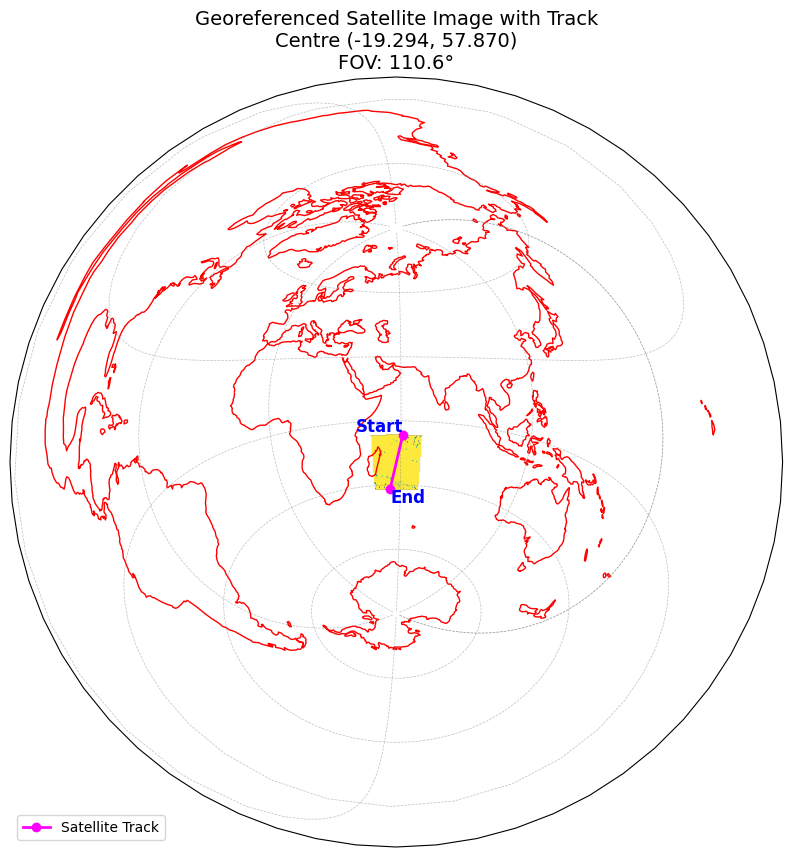

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cartopy.crs as ccrs
from scipy.ndimage import rotate

# --- Load image ---
img_path = "../data/2025-07-11_05-39_noaa_apt_137MHz/AVHRR-2.png"
img = np.array(Image.open(img_path).convert("L"), dtype=np.float32)

# --- Metrics from product ---
centre_lat = metrics['mid_subpoint']['lat_deg']
centre_lon = metrics['mid_subpoint']['lon_deg']
swath_km = metrics['across_track_swath_km']
track_km = metrics['along_track_length_km']

start_lat, start_lon = metrics['first_subpoint']['lat_deg'], metrics['first_subpoint']['lon_deg']
end_lat, end_lon = metrics['last_subpoint']['lat_deg'], metrics['last_subpoint']['lon_deg']

# --- Compute along-track orientation angle ---
delta_lat = end_lat - start_lat
delta_lon = end_lon - start_lon
angle_rad = np.arctan2(delta_lon, delta_lat)
angle_deg = np.rad2deg(angle_rad)

# --- Rotate image so along-track aligns north-south ---
img_rot = rotate(img, -angle_deg, reshape=True, order=1, mode='nearest')

# --- Compute extent in degrees ---
earth_radius_km = 6371.0
lat_extent = (track_km / 2) / (2 * np.pi * earth_radius_km / 360)
lon_extent = (swath_km / 2) / (2 * np.pi * earth_radius_km / 360 * np.cos(np.deg2rad(centre_lat)))

extent = [
    centre_lon - lon_extent, centre_lon + lon_extent,
    centre_lat - lat_extent, centre_lat + lat_extent
]

# --- Plot ---
proj = ccrs.AzimuthalEquidistant(central_longitude=centre_lon, central_latitude=centre_lat)
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=proj)

# Display rotated image
ax.imshow(img_rot, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap='viridis', alpha=0.9)

# Overlay coastlines and grid
ax.coastlines(resolution='110m', color='red')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray', alpha=0.5)
gl.top_labels = gl.right_labels = False

# Overlay satellite track
ax.plot([start_lon, end_lon], [start_lat, end_lat], color='magenta', linewidth=2,
        marker='o', transform=ccrs.PlateCarree(), label='Satellite Track')

# Annotate start and end points
ax.text(start_lon, start_lat, 'Start', color='blue', fontsize=12, fontweight='bold',
        transform=ccrs.PlateCarree(), ha='right', va='bottom')
ax.text(end_lon, end_lat, 'End', color='blue', fontsize=12, fontweight='bold',
        transform=ccrs.PlateCarree(), ha='left', va='top')

plt.title(f"Georeferenced Satellite Image with Track\nCentre ({centre_lat:.3f}, {centre_lon:.3f})\nFOV: {metrics['fov_deg']:.1f}°", fontsize=14)
plt.legend(loc='lower left')
plt.show()


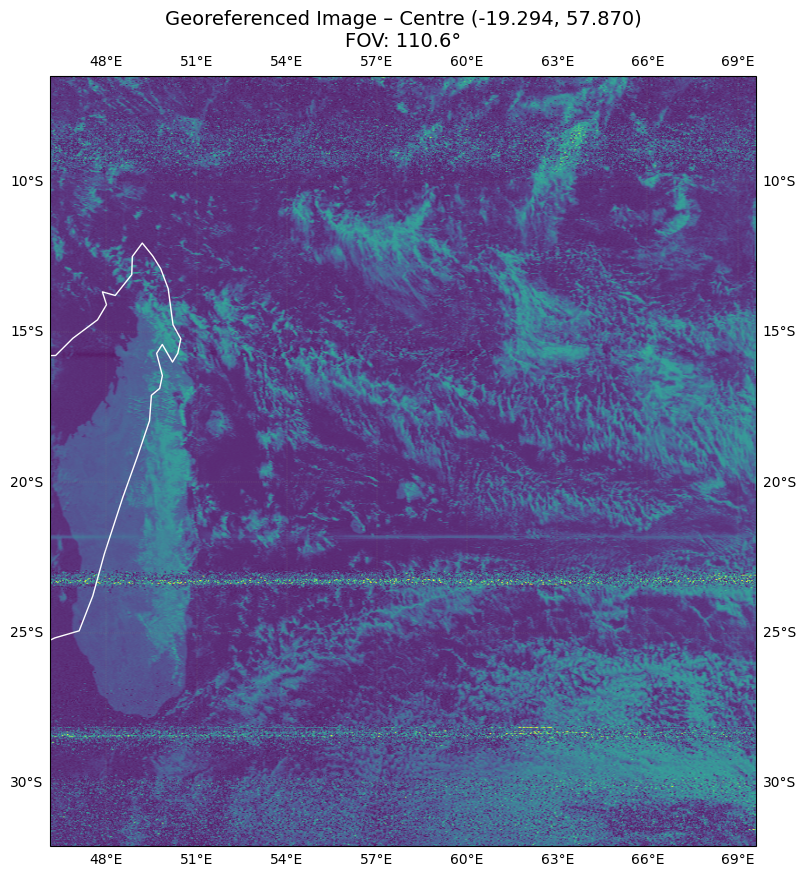

In [30]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# --- Load image ---
img_path = "../data/2025-07-11_05-39_noaa_apt_137MHz/AVHRR-2.png"
img = np.array(Image.open(img_path))


centre_lat = metrics['mid_subpoint']['lat_deg']
centre_lon = metrics['mid_subpoint']['lon_deg']
swath_km = metrics['across_track_swath_km']
track_km = metrics['along_track_length_km']

# --- Compute km per degree ---
earth_radius_km = 6371.0
km_per_deg_lat = (2 * np.pi * earth_radius_km) / 360.0
km_per_deg_lon = km_per_deg_lat * np.cos(np.deg2rad(centre_lat))

# --- Compute geographic half-extents ---
lat_half = (track_km / 2) / km_per_deg_lat
lon_half = (swath_km / 2) / km_per_deg_lon

extent = [
    centre_lon - lon_half, centre_lon + lon_half,
    centre_lat - lat_half, centre_lat + lat_half
]

# --- Plot ---
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m', color='white')
ax.gridlines(draw_labels=True, linewidth=0.3, linestyle='--', color='gray', alpha=0.5)

ax.imshow(img, extent=extent, transform=ccrs.PlateCarree(),
          origin='upper', alpha=0.9)

plt.title(f"Georeferenced Image – Centre ({centre_lat:.3f}, {centre_lon:.3f})\nFOV: {metrics['fov_deg']:.1f}°", fontsize=14)
plt.show()


Loaded image with 1 channel(s), shape=(860, 909)

--- Channel 1 Radiometric Stats ---
mean           : 12012.9512
std            : 8587.3320
min            : 0.0000
max            : 65535.0000
dynamic_range  : 65535.0000
snr_db         : 2.9158


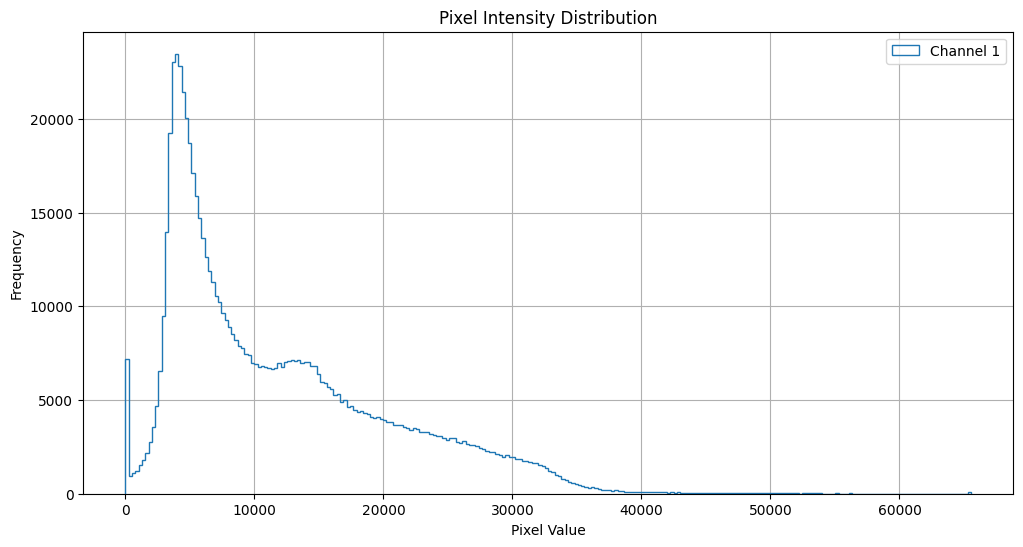

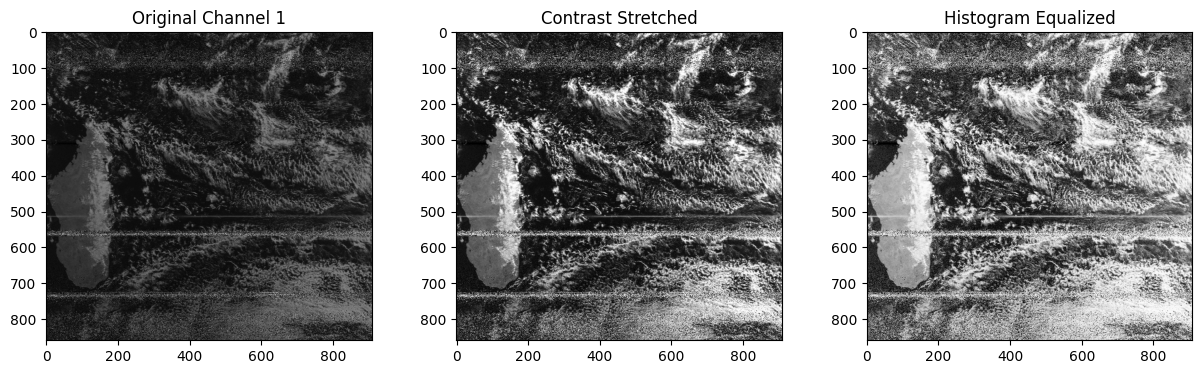


Channel 1:
  Underexposed pixels: 1.00%
  Overexposed pixels : 1.00%
{'channel_stats': [{'mean': np.float32(12012.951), 'std': np.float32(8587.332), 'min': np.float32(0.0), 'max': np.float32(65535.0), 'dynamic_range': np.float32(65535.0), 'snr_db': np.float32(2.9158287)}]}


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import exposure

# ===========================
# 1. Load Image
# ===========================

# Read image (keep float precision)
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

if img is None:
    raise FileNotFoundError(f"Could not load {image_path}")

# Convert to float32 for analysis
img = img.astype(np.float32)

# If image has multiple channels, split them
if len(img.shape) == 3:
    channels = cv2.split(img)
else:
    channels = [img]

print(f"Loaded image with {len(channels)} channel(s), shape={img.shape}")

# ===========================
# 2. Radiometric Statistics
# ===========================
def radiometric_stats(channel):
    mean = np.mean(channel)
    std = np.std(channel)
    min_val = np.min(channel)
    max_val = np.max(channel)
    dynamic_range = max_val - min_val
    snr = 10 * np.log10(mean**2 / std**2) if std > 0 else np.inf

    return {
        "mean": mean,
        "std": std,
        "min": min_val,
        "max": max_val,
        "dynamic_range": dynamic_range,
        "snr_db": snr,
    }

channel_stats = [radiometric_stats(ch) for ch in channels]

for i, stats in enumerate(channel_stats):
    print(f"\n--- Channel {i+1} Radiometric Stats ---")
    for k, v in stats.items():
        print(f"{k:15}: {v:.4f}")

# ===========================
# 3. Histogram Analysis
# ===========================
plt.figure(figsize=(12, 6))
for i, ch in enumerate(channels):
    plt.hist(ch.ravel(), bins=256, histtype='step', label=f'Channel {i+1}')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# ===========================
# 4. Image Contrast & Exposure
# ===========================
for i, ch in enumerate(channels):
    # Compute histogram equalization and contrast stretching
    p2, p98 = np.percentile(ch, (2, 98))
    stretched = exposure.rescale_intensity(ch, in_range=(p2, p98))
    eq = exposure.equalize_hist(ch)

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    axs[0].imshow(ch, cmap='gray')
    axs[0].set_title(f'Original Channel {i+1}')
    axs[1].imshow(stretched, cmap='gray')
    axs[1].set_title('Contrast Stretched')
    axs[2].imshow(eq, cmap='gray')
    axs[2].set_title('Histogram Equalized')
    plt.show()

# ===========================
# 5. Exposure / Clipping Detection
# ===========================
def exposure_quality(channel, low_thresh=0.01, high_thresh=0.99):
    """Detect over/underexposure by checking pixel percentile clipping."""
    low_val, high_val = np.percentile(channel, [low_thresh * 100, high_thresh * 100])
    underexposed = np.sum(channel <= low_val) / channel.size
    overexposed = np.sum(channel >= high_val) / channel.size
    return underexposed, overexposed

for i, ch in enumerate(channels):
    under, over = exposure_quality(ch)
    print(f"\nChannel {i+1}:")
    print(f"  Underexposed pixels: {under * 100:.2f}%")
    print(f"  Overexposed pixels : {over * 100:.2f}%")

# ===========================
# 6. Optional: Save Analysis Summary
# ===========================
import json
summary = {"channel_stats": channel_stats}
# with open("radiometric_analysis_summary.json", "w") as f:
#     json.dump(summary, f, indent=4)
# print("\n Radiometric analysis summary saved to 'radiometric_analysis_summary.json'")
print(summary)

# Temporal Analysis of SatDump Images
This section demonstrates how to perform **temporal analysis** using satellite images obtained from SatDump.

Temporal analysis means comparing **multiple images of the same region captured at different times** to identify:
- **Long-term changes** (e.g., vegetation growth, deforestation, urban development)
- **Short-term events or transients** (e.g., clouds, fires, floods)

We will use two example SatDump images captured at different times and perform:

1. **Change Detection** – Identify permanent or semi-permanent changes in the scene.  
2. **Transient Detection** – Detect temporary phenomena that appear in one image but not the other.


We will use:
- **NumPy** for numerical operations.
- **OpenCV (cv2)** for image reading and manipulation.
- **Matplotlib** for visualization.


### Step 2 Explanation
We load two SatDump images — both covering the same area but at different times.

- The images are converted to `float32` for numerical precision.
- If the data are RGB (multi-band), we convert them to grayscale for simplicity.
- The images must have the same shape to compare pixel-by-pixel; if not, we resize the second image to match.

### Step 3 Explanation
Images can have different brightness or scaling values.
We normalize both to a range of `[0, 1]` so that the comparison is consistent and not biased by differences in image brightness.

### Step 4 Explanation
To find changes, we subtract pixel intensities between the two dates:
$$
[D = I_{t2} - I_{t1}]
$$
- A large positive difference means the area brightened.
- A large negative difference means it darkened.
- Small differences may indicate noise or unchanged regions.

We then apply a **threshold** (0.15 here) to decide which pixels represent meaningful changes.
The result is a binary **change mask**, where 1 = changed and 0 = unchanged.

### Step 5 Explanation
**Transient detection** focuses on identifying events that appear briefly in the later image and disappear again later.

For example:
- Clouds or fires appear as new bright regions.
- Flooding may increase brightness in specific areas.
  
We apply:
- A threshold on positive brightness changes.
- Morphological filtering to remove small random noise.


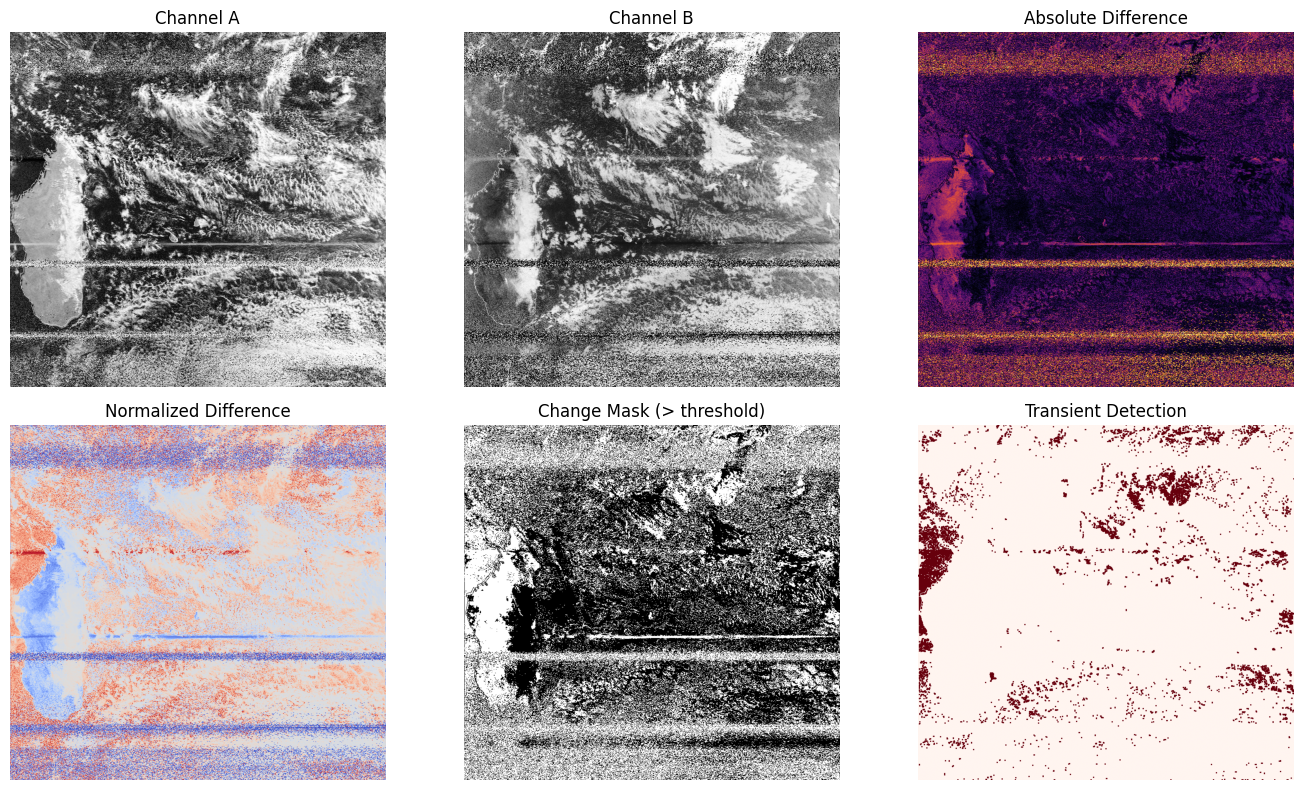


Change area: 47.09% of image
Transient area: 7.13% of image


In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ===========================
# 1. Load two SatDump images
# ===========================
img_t1 = cv2.imread("../data/2025-07-11_05-39_noaa_apt_137MHz/avhrr_3_APT_channel_A_map.jpg", cv2.IMREAD_UNCHANGED).astype(np.float32)
img_t2 = cv2.imread("../data/2025-07-11_05-39_noaa_apt_137MHz/avhrr_3_APT_channel_B_map.jpg", cv2.IMREAD_UNCHANGED).astype(np.float32)

# Convert to grayscale if needed
if img_t1.ndim == 3:
    img_t1 = cv2.cvtColor(img_t1, cv2.COLOR_BGR2GRAY)
if img_t2.ndim == 3:
    img_t2 = cv2.cvtColor(img_t2, cv2.COLOR_BGR2GRAY)

# Optional: resize if dimensions differ slightly
if img_t1.shape != img_t2.shape:
    img_t2 = cv2.resize(img_t2, (img_t1.shape[1], img_t1.shape[0]))

# ===========================
# 2. Normalize to [0,1]
# ===========================
img_t1 = cv2.normalize(img_t1, None, 0, 1, cv2.NORM_MINMAX)
img_t2 = cv2.normalize(img_t2, None, 0, 1, cv2.NORM_MINMAX)

# ===========================
# 3. Change Detection
# ===========================
diff = img_t2 - img_t1                     # signed difference
abs_diff = np.abs(diff)                    # absolute change
norm_diff = (diff) / (img_t2 + img_t1 + 1e-6)  # normalized difference

# Threshold for significant change
threshold = 0.15
change_mask = (abs_diff > threshold).astype(np.uint8)

# ===========================
# 4. Transient Detection
# ===========================
# Simple transient = brightening beyond threshold
transient_mask = ((img_t2 - img_t1) > threshold).astype(np.uint8)

# Remove small noise via morphological opening
kernel = np.ones((3, 3), np.uint8)
transient_mask = cv2.morphologyEx(transient_mask, cv2.MORPH_OPEN, kernel)

# ===========================
# 5. Visualization
# ===========================
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
axs[0, 0].imshow(img_t1, cmap='gray'); axs[0, 0].set_title("Channel A")
axs[0, 1].imshow(img_t2, cmap='gray'); axs[0, 1].set_title("Channel B")
axs[0, 2].imshow(abs_diff, cmap='inferno'); axs[0, 2].set_title("Absolute Difference")

axs[1, 0].imshow(norm_diff, cmap='coolwarm'); axs[1, 0].set_title("Normalized Difference")
axs[1, 1].imshow(change_mask, cmap='gray'); axs[1, 1].set_title("Change Mask (> threshold)")
axs[1, 2].imshow(transient_mask, cmap='Reds'); axs[1, 2].set_title("Transient Detection")
for ax in axs.flat: ax.axis('off')
plt.tight_layout()
plt.show()

# ===========================
# 6. Summary Statistics
# ===========================
change_ratio = np.sum(change_mask) / change_mask.size * 100
transient_ratio = np.sum(transient_mask) / transient_mask.size * 100

print(f"\nChange area: {change_ratio:.2f}% of image")
print(f"Transient area: {transient_ratio:.2f}% of image")



### Step 6 Explanation
This visualization shows:
- **Top row:** Original images and their absolute difference.
- **Bottom row:** Normalized difference, binary change mask, and transient detection mask.

The colors make it easier for students to visually compare which areas changed or experienced short-lived events.

### Step 7 Explanation
We calculate the proportion of pixels that changed or showed transients.

These percentages give a quick numerical summary of how much the observed region has evolved between the two timestamps.


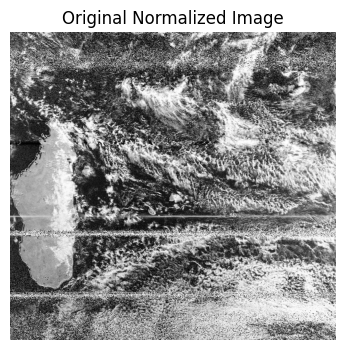

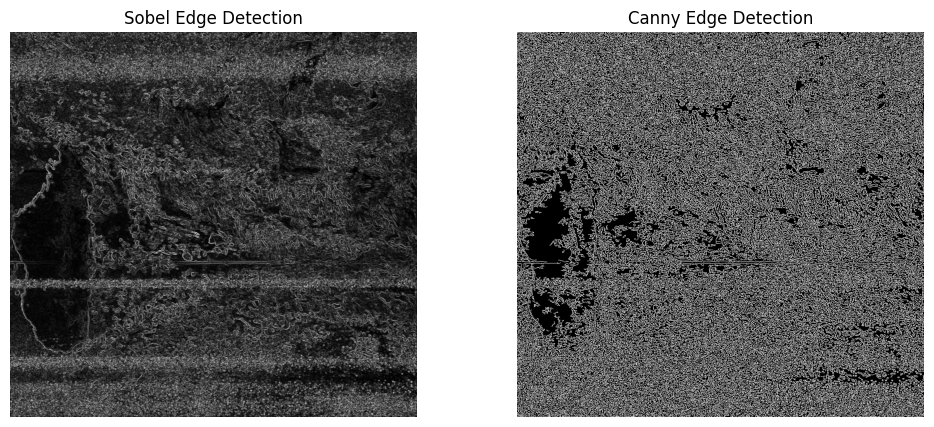

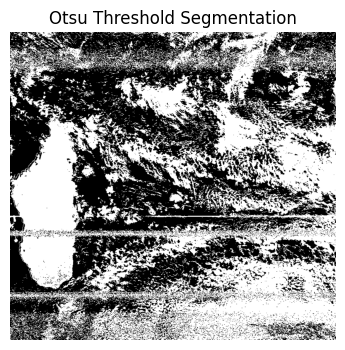

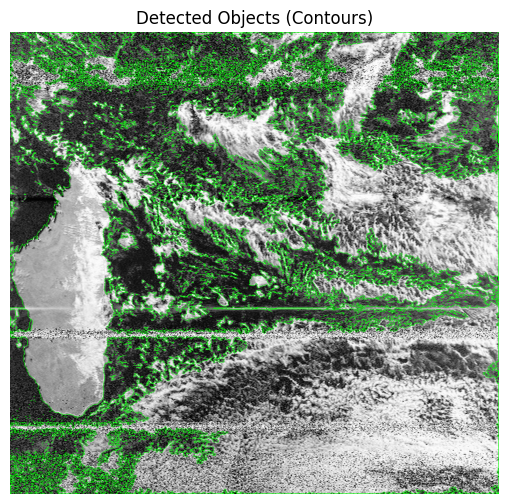

Detected 4937 potential objects/features.


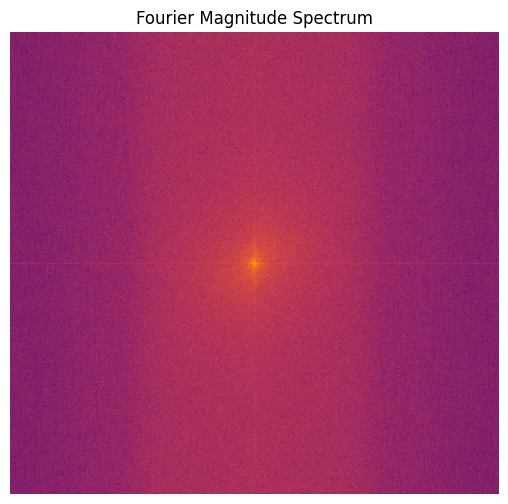

Approximate stripe/pattern intensity: -127.54

 Feature extraction analysis complete. Results saved to 'feature_extraction_summary.json'


In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack

# ===============================
# FEATURE EXTRACTION ANALYSIS
# ===============================
# This script performs edge detection, segmentation, object detection,
# and pattern recognition on a SatDump image.
# Ensure your image is grayscale or a single band (e.g., red or near-IR channel).

# ---- STEP 1: Load and preprocess the image ----
img_path = "../data/2025-07-11_05-39_noaa_apt_137MHz/avhrr_3_APT_channel_A_map.jpg" 
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    raise FileNotFoundError(f"Cannot read image at {img_path}")

# Normalize for consistent intensity
image_norm = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
plt.figure(figsize=(10, 4))
plt.title("Original Normalized Image")
plt.imshow(image_norm, cmap="gray")
plt.axis("off")
plt.show()

# ---- STEP 2: Edge Detection ----
# We'll compare Sobel and Canny edge detectors.
sobelx = cv2.Sobel(image_norm, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(image_norm, cv2.CV_64F, 0, 1, ksize=3)
sobel_edges = np.hypot(sobelx, sobely)

canny_edges = cv2.Canny(image_norm, 50, 150)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Sobel Edge Detection")
plt.imshow(sobel_edges, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Canny Edge Detection")
plt.imshow(canny_edges, cmap="gray")
plt.axis("off")
plt.show()

# ---- STEP 3: Segmentation (Otsu Thresholding) ----
otsu_val, otsu_thresh = cv2.threshold(image_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(8, 4))
plt.title("Otsu Threshold Segmentation")
plt.imshow(otsu_thresh, cmap="gray")
plt.axis("off")
plt.show()

# ---- STEP 4: Object Detection via Contours ----
# Find contours (edges of segmented regions)
contours, _ = cv2.findContours(otsu_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = cv2.cvtColor(image_norm, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 1)

plt.figure(figsize=(10, 6))
plt.title("Detected Objects (Contours)")
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print(f"Detected {len(contours)} potential objects/features.")

# ---- STEP 5: Pattern Recognition (Fourier Spectrum) ----
# The FFT reveals repeating structures or artifacts.
F = fftpack.fft2(image_norm)
Fshift = fftpack.fftshift(F)
magnitude_spectrum = 20 * np.log(np.abs(Fshift) + 1)

plt.figure(figsize=(8, 6))
plt.title("Fourier Magnitude Spectrum")
plt.imshow(magnitude_spectrum, cmap="inferno")
plt.axis("off")
plt.show()

# Optional: detect dominant frequency peaks
rows, cols = image_norm.shape
crow, ccol = rows // 2, cols // 2
center_value = magnitude_spectrum[crow, ccol]
stripe_intensity = np.mean(magnitude_spectrum[crow-50:crow+50, ccol-50:ccol+50]) - center_value
print(f"Approximate stripe/pattern intensity: {stripe_intensity:.2f}")

# ---- Summary for Logging ----
feature_summary = {
    "edge_detection": {
        "sobel_mean_intensity": float(np.mean(sobel_edges)),
        "canny_edge_density": float(np.count_nonzero(canny_edges) / canny_edges.size)
    },
    "segmentation": {
        "otsu_threshold": float(otsu_val),
        "object_count": len(contours)
    },
    "pattern_recognition": {
        "stripe_intensity_metric": float(stripe_intensity)
    }
}

import json
with open("feature_extraction_summary.json", "w") as f:
    json.dump(feature_summary, f, indent=4)

print("\n Feature extraction analysis complete. Results saved to 'feature_extraction_summary.json'")


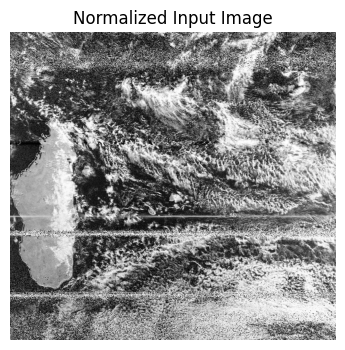

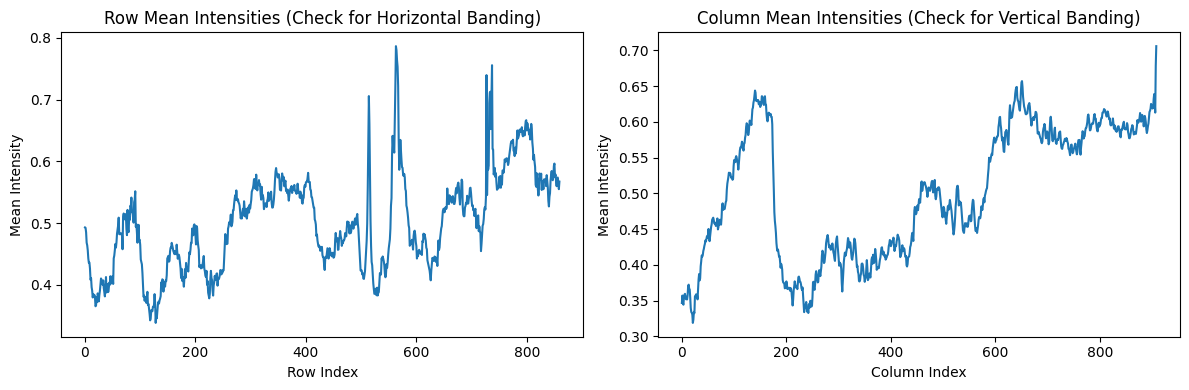

Row stripe strength: 0.1549
Column stripe strength: 0.1828
Estimated SNR: 1.73
Hot pixels detected: 0
Dead pixels detected: 0
Motion blur metric: 2.416528

 Quality/Health analysis complete. Results saved to 'quality_health_analysis_summary.json'


In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

# ===============================
# QUALITY / HEALTH ANALYSIS
# ===============================
# This code checks the health of the satellite image by analyzing
# striping/banding, SNR, and artifacts such as hot/dead pixels and blur.

# ---- STEP 1: Load and normalize the image ----
img_path = "../data/2025-07-11_05-39_noaa_apt_137MHz/avhrr_3_APT_channel_A_map.jpg"   # replace with your file
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Cannot read image at {img_path}")

# Normalize to 0–1 range
image_norm = cv2.normalize(image.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)

plt.figure(figsize=(8, 4))
plt.title("Normalized Input Image")
plt.imshow(image_norm, cmap="gray")
plt.axis("off")
plt.show()

# ---- STEP 2: Striping / Banding Detection ----
# Compute mean intensity per row and per column
row_means = np.mean(image_norm, axis=1)
col_means = np.mean(image_norm, axis=0)

# Stripe strength metrics
row_stripe_strength = np.std(row_means) / np.mean(row_means)
col_stripe_strength = np.std(col_means) / np.mean(col_means)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(row_means)
plt.title("Row Mean Intensities (Check for Horizontal Banding)")
plt.xlabel("Row Index")
plt.ylabel("Mean Intensity")

plt.subplot(1, 2, 2)
plt.plot(col_means)
plt.title("Column Mean Intensities (Check for Vertical Banding)")
plt.xlabel("Column Index")
plt.ylabel("Mean Intensity")
plt.tight_layout()
plt.show()

print(f"Row stripe strength: {row_stripe_strength:.4f}")
print(f"Column stripe strength: {col_stripe_strength:.4f}")

# ---- STEP 3: SNR Analysis ----
signal_mean = np.mean(image_norm)
noise_std = np.std(image_norm)
snr = signal_mean / noise_std if noise_std > 0 else np.inf
print(f"Estimated SNR: {snr:.2f}")

# ---- STEP 4: Artifact Detection ----
# Define thresholds for hot and dead pixels
hot_threshold = np.mean(image_norm) + 3 * np.std(image_norm)
dead_threshold = np.mean(image_norm) - 3 * np.std(image_norm)

hot_pixels = np.sum(image_norm > hot_threshold)
dead_pixels = np.sum(image_norm < dead_threshold)

# ---- Detect motion blur (via gradient variance) ----
gx = cv2.Sobel(image_norm, cv2.CV_64F, 1, 0, ksize=3)
gy = cv2.Sobel(image_norm, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = np.sqrt(gx**2 + gy**2)
gradient_variance = np.var(gradient_magnitude)
blur_metric = 1 / (gradient_variance + 1e-8)  # higher = blurrier

print(f"Hot pixels detected: {hot_pixels}")
print(f"Dead pixels detected: {dead_pixels}")
print(f"Motion blur metric: {blur_metric:.6f}")

# ---- STEP 5: Summary Report ----
quality_summary = {
    "striping_banding": {
        "row_stripe_strength": float(row_stripe_strength),
        "col_stripe_strength": float(col_stripe_strength)
    },
    "snr_analysis": {
        "signal_mean": float(signal_mean),
        "noise_std": float(noise_std),
        "snr": float(snr)
    },
    "artifact_detection": {
        "hot_pixels": int(hot_pixels),
        "dead_pixels": int(dead_pixels),
        "motion_blur_metric": float(blur_metric)
    }
}

with open("quality_health_analysis_summary.json", "w") as f:
    json.dump(quality_summary, f, indent=4)

print("\n Quality/Health analysis complete. Results saved to 'quality_health_analysis_summary.json'")


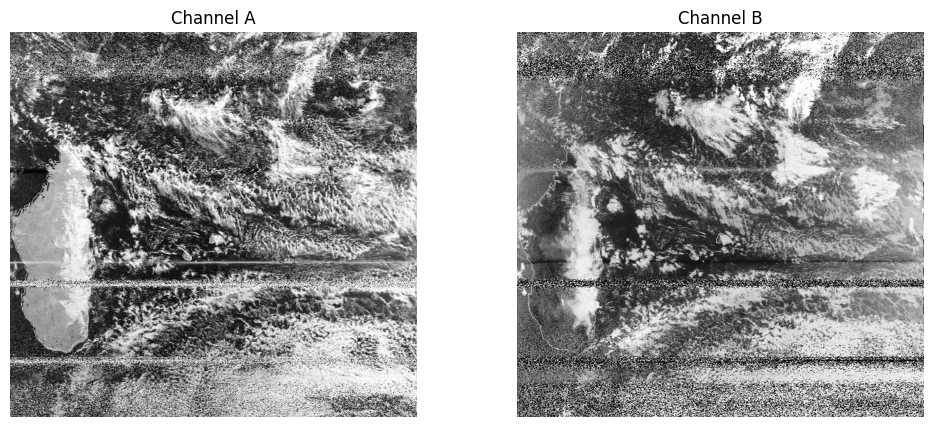

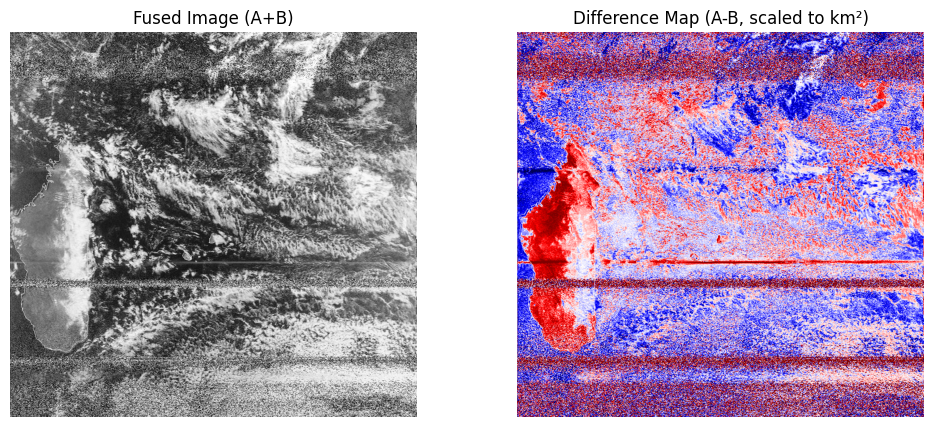

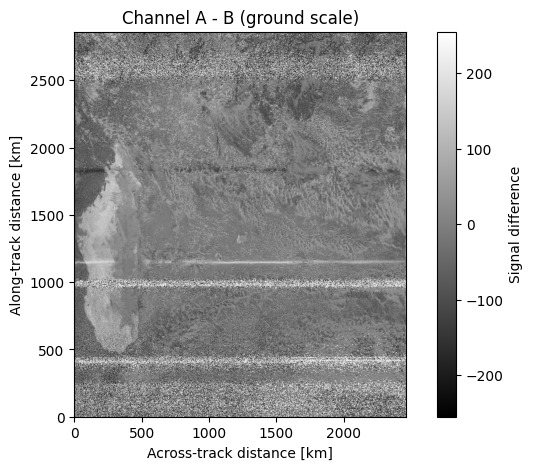

Advanced analysis complete. Summary saved to 'advanced_analysis_summary.json'


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from rasterio.transform import from_bounds
import json

# --- FILE PATHS ---
channel_a_path = "../data/2025-07-11_05-39_noaa_apt_137MHz/avhrr_3_APT_channel_A_map.jpg"
channel_b_path = "../data/2025-07-11_05-39_noaa_apt_137MHz/avhrr_3_APT_channel_B_map.jpg"

# --- STEP 0: Load images ---
img_a = np.array(Image.open(channel_a_path).convert('L'), dtype=np.float32)
img_b = np.array(Image.open(channel_b_path).convert('L'), dtype=np.float32)
height, width = img_a.shape

# --- STEP 1: Apply provided metrics ---
# metrics = {
#     'image_width_px': 909,
#     'image_height_px': 860,
#     'along_track_length_km': 2860.4033,
#     'along_track_pixel_size_m': 3326.0504,
#     'across_track_swath_km': 2463.1786,
#     'across_track_pixel_size_m': 2709.7675,
#     'per_pixel_area_km2': 9.012823
# }

# Ground-referenced distances
along_track_km = metrics['along_track_length_km']
swath_km = metrics['across_track_swath_km']
per_pixel_km2 = metrics['per_pixel_area_km2']

# --- STEP 2: Visualize the original images ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_a, cmap='gray')
plt.title("Channel A")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_b, cmap='gray')
plt.title("Channel B")
plt.axis("off")
plt.show()

# --- STEP 3: Difference / Fusion ---
fused = (img_a + img_b) / 2.0
difference = img_a - img_b

# Scale difference by per-pixel ground area for teaching purposes
difference_ground = difference / per_pixel_km2

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].imshow(fused, cmap='gray')
ax[0].set_title("Fused Image (A+B)")
ax[0].axis("off")

ax[1].imshow(difference_ground, cmap='seismic', 
             vmin=-np.std(difference_ground)*2, vmax=np.std(difference_ground)*2)
ax[1].set_title("Difference Map (A-B, scaled to km²)")
ax[1].axis("off")
plt.show()

# --- STEP 4: Ground-referenced plot ---
plt.figure(figsize=(8,5))
plt.imshow(difference, cmap='gray', extent=[0, swath_km, 0, along_track_km], origin='upper')
plt.title("Channel A - B (ground scale)")
plt.xlabel("Across-track distance [km]")
plt.ylabel("Along-track distance [km]")
plt.colorbar(label="Signal difference")
plt.show()

# --- STEP 5: Save summary ---
advanced_summary = {
    "fusion": {
        "performed": True,
        "fused_mean": float(np.mean(fused)),
        "difference_mean": float(np.mean(difference))
    },
    "metrics": metrics
}

with open("advanced_analysis_summary.json", "w") as f:
    json.dump(advanced_summary, f, indent=4)

print("Advanced analysis complete. Summary saved to 'advanced_analysis_summary.json'")


In [ ]:
-27.887680146538468, -128.08267889973436